In [16]:
import torch #Main PyTorch library for tensor computation and GPU support
import torch.nn as nn # Provides neural network layers and building blocks
import torch.nn.functional as F #Provides neural network layers and building blocks
import torch.optim as optim #Provides optimization algorithms like SGD, Adam, etc.
from torch.utils.data import DataLoader #Utility to batch, shuffle, and load data in parallel.
import torchvision #Popular computer vision library with datasets and models.
import torchvision.transforms as transforms #Used for preprocessing like normalization or converting images to tensors.
from torchsummary import summary
# !pip install torchviz
from torchviz import make_dot
from IPython.display import Image
# !pip install graphviz
from graphviz import Digraph


import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')
import random


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [17]:
# =====================================
# 1. IMPORT EVERYTHING & DATA SETUP
# =====================================

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and prepare datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

#Creates an iterable for training data in batches of 64.
#Shuffling the data helps prevent overfitting and ensures better training.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 60000
Test samples: 10000


In [18]:
# =====================================
# 2. NEURAL NETWORK MODEL
# =====================================
#Mnist image is 28X28 1channel-grayscale

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #1-input channel, produce 32 output channel, kernel 3x3, stride of 1, no padding 28x28->26x26
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  #64 filters on the 32 feature map from conv1 by 3x3 kernel 26x26->24x24
        self.dropout1 = nn.Dropout2d(0.25) #Applies dropout (randomly zeroing out channels) with probability 25% after pooling. Helps prevent overfitting.
        self.dropout2 = nn.Dropout2d(0.5) #A second dropout layer (50%) applied before the final output layer.
        self.fc1 = nn.Linear(9216, 128) #Fully connected layer: input features = 9216, output = 128. 24x24 → 12x12 64*12*12=9216
        self.fc2 = nn.Linear(128, 10) #Final layer: maps the 128 features to 10 output classes (digits 0–9).

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [19]:
# =====================================
# 3. QUANTIZATION FUNCTIONS
# =====================================

def quantize_weights_int8(weights):
    """
    Quantize weights to 8-bit integers (1 byte per weight)
    input take weight which are float32

    """
    # Find min and max values
    w_min = weights.min()
    w_max = weights.max()

    # Calculate scale and zero point
    scale = (w_max - w_min) / 255.0
    zero_point = torch.round(-w_min / scale).clamp(0, 255) #ensures that the mapping preserves the original values.

    # Quantize
    quantized = torch.round(weights / scale + zero_point).clamp(0, 255)

    # Store quantization parameters
    return quantized.to(torch.uint8), scale, zero_point

def dequantize_weights_int8(quantized_weights, scale, zero_point):
    """
    Convert quantized weights back to float32
    """
    return scale * (quantized_weights.float() - zero_point)

def quantize_model_weights(model):
    """Fixed quantization function that properly handles all parameters"""
    from copy import deepcopy
    quantized_model = deepcopy(model).to(device)
    quant_params = {}

    with torch.no_grad():
        for name, param in quantized_model.named_parameters():
            if param.requires_grad:  # Only quantize trainable parameters
                data = param.data
                max_abs = torch.max(torch.abs(data)).item()
                scale = max_abs / 127.0 if max_abs > 0 else 1.0

                quant_params[name] = scale
                quantized = torch.round(data / scale).clamp(-128, 127).to(torch.int8)

                # 🔥 Ensure _quantized is attached to ALL parameters
                param._quantized = quantized.clone()

                # Set dequantized weights back
                param.data.copy_(quantized.to(torch.float32) * scale)
                
                print(f"[DEBUG] Quantized {name}: shape={param.shape}, scale={scale:.6f}")

    return quantized_model, quant_params


In [20]:
# =====================================
# 4. TRAINING FUNCTION
# =====================================

def train_model(model, train_loader, epochs=5):
    """Train the model"""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001) #Uses the Adam optimizer to update model weights.

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad() #Resets gradients from the previous batch.
            output = model(data) #Performs a forward pass to get predictions.
            loss = F.nll_loss(output, target) #Computes negative log-likelihood loss between predicted log-probabilities and ground truth.
            loss.backward() #Backpropagates the loss to compute gradients
            optimizer.step() #Updates model weights based on gradients.
            total_loss += loss.item()

            if batch_idx % 300 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.6f}')


        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1} completed. Average Loss: {avg_loss:.6f}')

In [21]:
# =====================================
# 5. TEST BENCH FUNCTION
# =====================================

def test_model(model, test_loader, model_name="Model"):
    """Test the model and return accuracy"""
    model.eval() #Disables layers like dropout and batch norm from updating.
    #Ensures consistent behavior during testing.
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): #Prevents PyTorch from computing gradients
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Computes total negative log-likelihood loss over the batch (using sum for aggregation).
            # Accumulates the total test loss across all batches.
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= total
    accuracy = 100. * correct / total

    print(f'{model_name} - Test Loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)')
    return accuracy, test_loss

In [22]:
# =====================================
# 6. ANALYSIS AND PLOTTING FUNCTIONS
# =====================================

def analyze_weight_distribution(model, title="Weight Distribution"):
    """Analyze and plot weight distributions"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title)

    layer_idx = 0
    for name, param in model.named_parameters():
        if 'weight' in name and layer_idx < 4:
            weights = param.data.cpu().numpy().flatten()
            ax = axes[layer_idx // 2, layer_idx % 2]
            ax.hist(weights, bins=50, alpha=0.7)
            ax.set_title(f'{name}')
            ax.set_xlabel('Weight Value')
            ax.set_ylabel('Frequency')
            layer_idx += 1

    plt.tight_layout()
    plt.show()

def plot_accuracy_comparison(results):
    """Plot accuracy comparison"""
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'][:len(models)])
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 100)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def calculate_memory_usage(model, quantized_params=None):
    """Calculate memory usage of the model"""
    total_params = 0
    fp32_size = 0
    int8_size = 0

    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        fp32_size += param_count * 4  # 4 bytes per float32

        if quantized_params and name in quantized_params:
            int8_size += param_count * 1  # 1 byte per int8
        else:
            int8_size += param_count * 4  # Keep as float32 if not quantized

    print(f"Total parameters: {total_params:,}")
    print(f"FP32 model size: {fp32_size / 1024:.2f} KB")
    print(f"INT8 model size: {int8_size / 1024:.2f} KB")
    print(f"Compression ratio: {fp32_size / int8_size:.2f}x")

    return total_params, fp32_size, int8_size


MNIST 8-bit Weight Quantization Analysis

1. Training Original Model...
Epoch 1/3, Batch 0, Loss: 2.323443
Epoch 1/3, Batch 300, Loss: 0.205323
Epoch 1/3, Batch 600, Loss: 0.052456
Epoch 1/3, Batch 900, Loss: 0.032313
Epoch 1 completed. Average Loss: 0.205110
Epoch 2/3, Batch 0, Loss: 0.030943
Epoch 2/3, Batch 300, Loss: 0.050873
Epoch 2/3, Batch 600, Loss: 0.074924
Epoch 2/3, Batch 900, Loss: 0.081291
Epoch 2 completed. Average Loss: 0.085931
Epoch 3/3, Batch 0, Loss: 0.076244
Epoch 3/3, Batch 300, Loss: 0.157751
Epoch 3/3, Batch 600, Loss: 0.087140
Epoch 3/3, Batch 900, Loss: 0.063984
Epoch 3 completed. Average Loss: 0.068045
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
         Dropout2d-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 

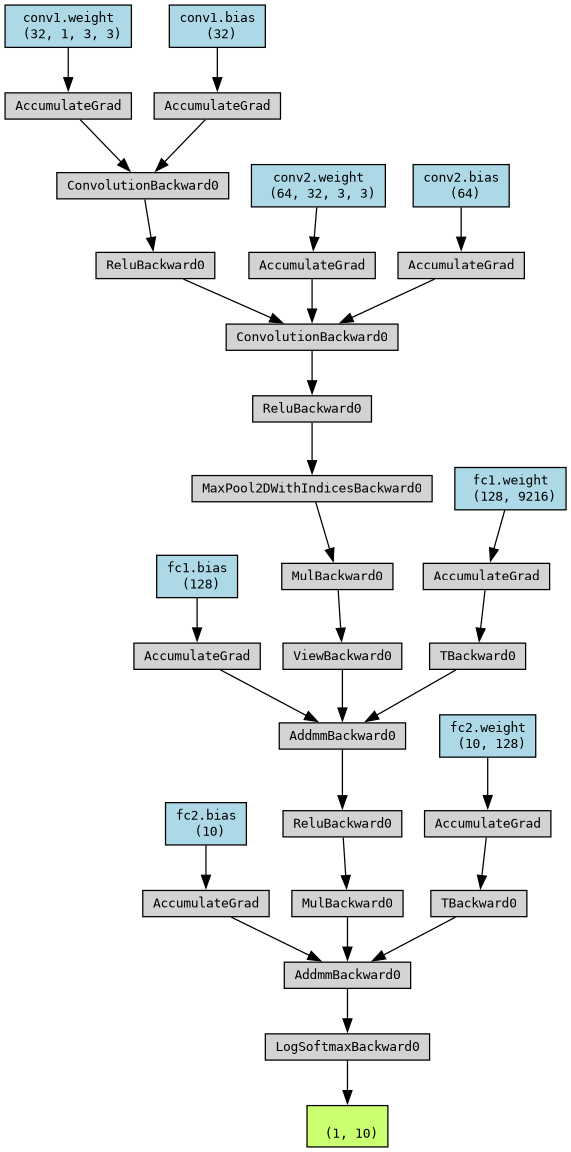


2. Testing Original Model...
Original FP32 - Test Loss: 0.0305, Accuracy: 9907/10000 (99.07%)

3. Quantizing Model Weights to 8-bit...
[DEBUG] Quantized conv1.weight: shape=torch.Size([32, 1, 3, 3]), scale=0.003997
[DEBUG] Quantized conv1.bias: shape=torch.Size([32]), scale=0.002096
[DEBUG] Quantized conv2.weight: shape=torch.Size([64, 32, 3, 3]), scale=0.002671
[DEBUG] Quantized conv2.bias: shape=torch.Size([64]), scale=0.000686
[DEBUG] Quantized fc1.weight: shape=torch.Size([128, 9216]), scale=0.002257
[DEBUG] Quantized fc1.bias: shape=torch.Size([128]), scale=0.000651
[DEBUG] Quantized fc2.weight: shape=torch.Size([10, 128]), scale=0.001860
[DEBUG] Quantized fc2.bias: shape=torch.Size([10]), scale=0.001027
Quantized INT8 - Test Loss: 0.0304, Accuracy: 9905/10000 (99.05%)

4. Memory Usage Analysis...
Total parameters: 1,199,882
FP32 model size: 4687.04 KB
INT8 model size: 1171.76 KB
Compression ratio: 4.00x

5. Analyzing Weight Distributions...


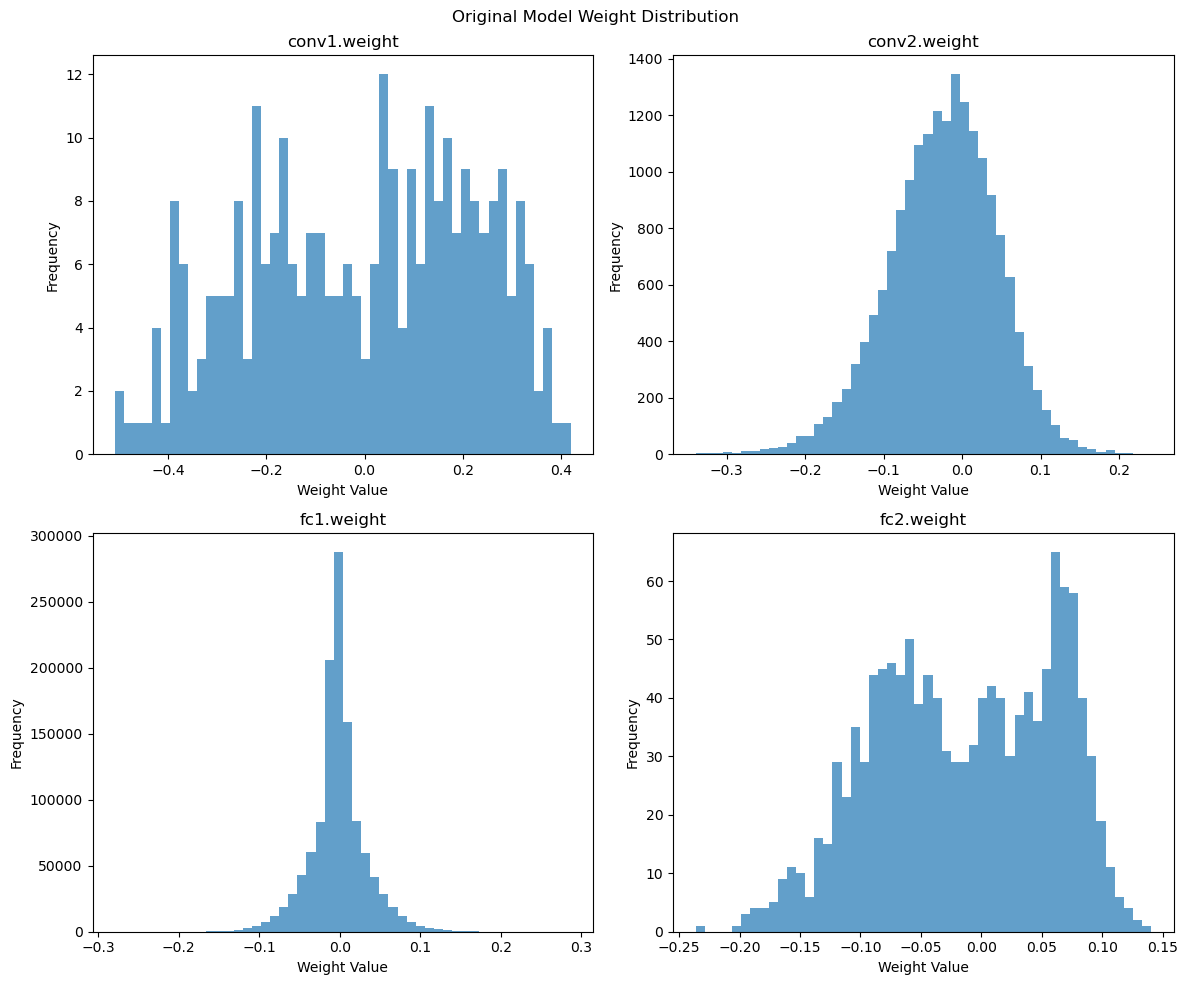

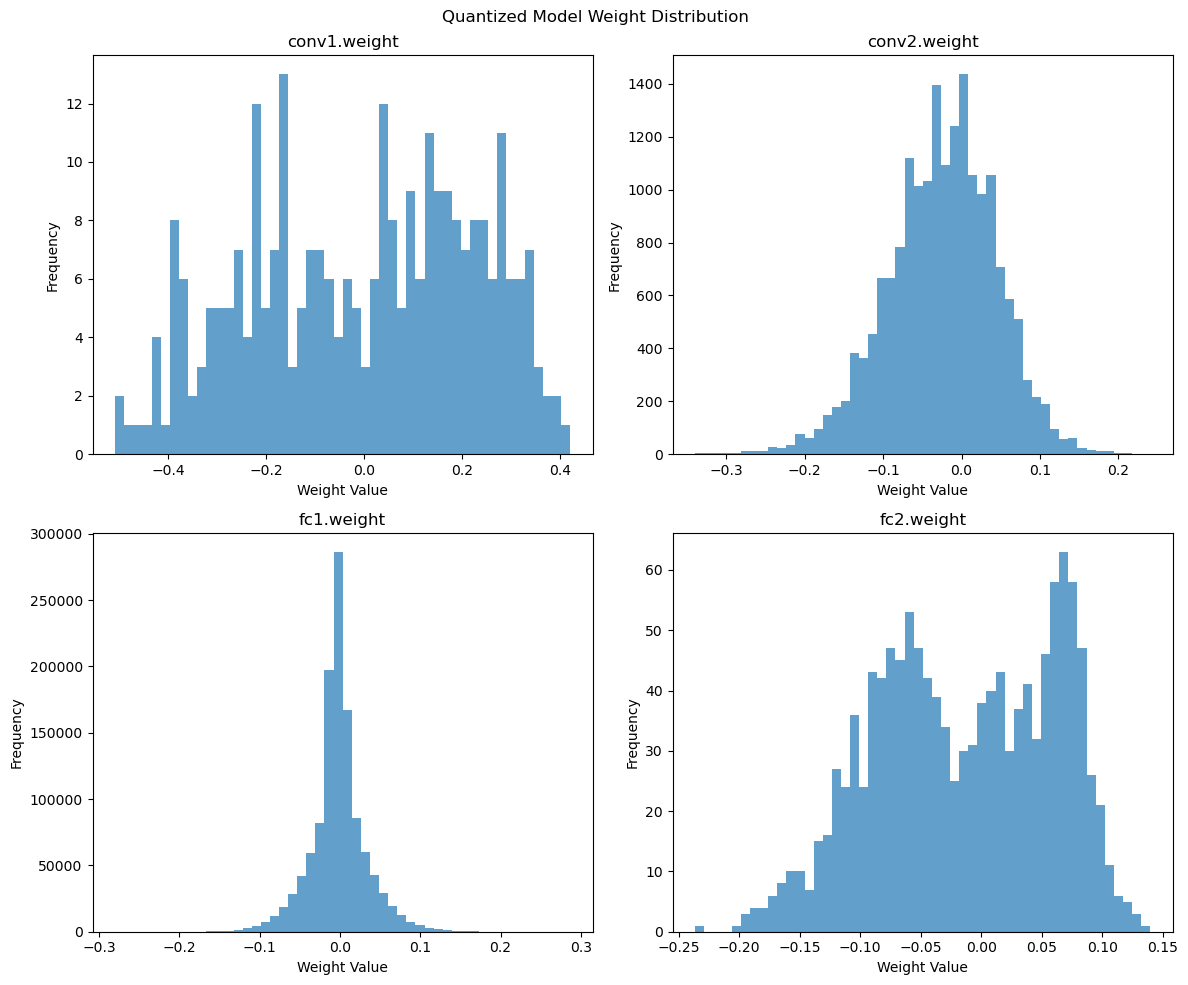

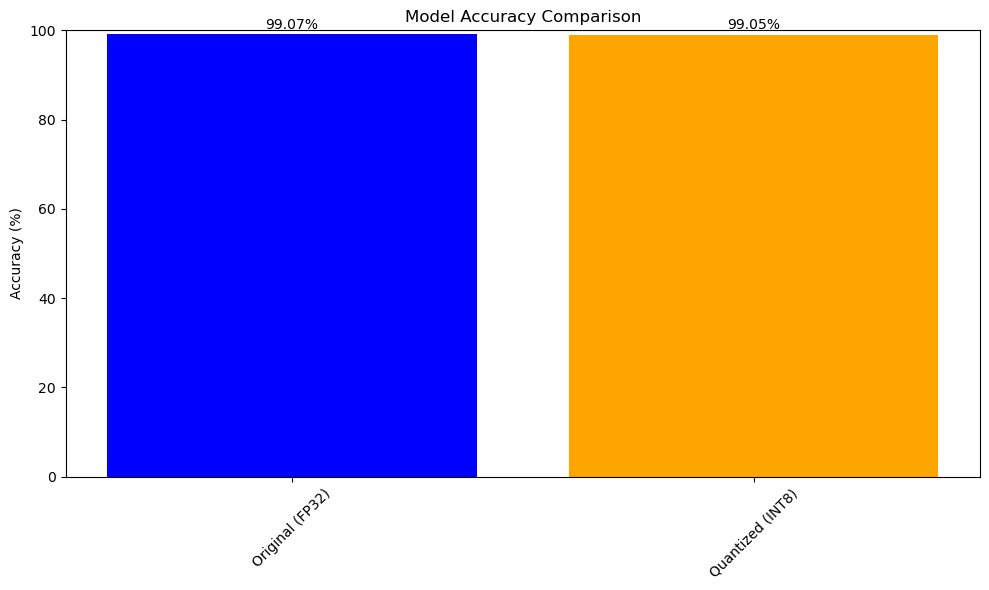


SETUP COMPLETE!
Ready for weight modifications!
Use the following functions to modify weights:
- modify_weights_percentage(model, percentage, layer_name)
- modify_specific_weights(model, weight_indices, new_values, layer_name)
- test_model(modified_model, test_loader, 'Modified Model')
- plot_accuracy_comparison(results)


In [23]:
# =====================================
# 7. MAIN EXECUTION REGULAR PIPELINE
# =====================================

def main():
    print("=" * 60)
    print("MNIST 8-bit Weight Quantization Analysis")
    print("=" * 60)

    # Initialize and train the original model
    print("\n1. Training Original Model...")
    original_model = MNISTNet().to(device)
    train_model(original_model, train_loader, epochs=3)

    # Create model and display summary
    summary(original_model, input_size=(1, 28, 28))

    x = torch.randn(1, 1, 28, 28).to(device)  # Simulated MNIST input
    y = original_model(x)

    make_dot(y, params=dict(original_model.named_parameters())).render("mnist_net", format="png")
    display(Image(filename="mnist_net.png"))  # ✅ show in notebook


    # Test original model
    print("\n2. Testing Original Model...")
    original_accuracy, original_loss = test_model(original_model, test_loader, "Original FP32")

    # Quantize model weights
    print("\n3. Quantizing Model Weights to 8-bit...")
    quantized_model, quant_params = quantize_model_weights(original_model)
    quantized_accuracy, quantized_loss = test_model(quantized_model, test_loader, "Quantized INT8")

    # Calculate memory usage
    print("\n4. Memory Usage Analysis...")
    calculate_memory_usage(original_model, quant_params)

    # Store results for comparison
    results = {
        'Original (FP32)': {'accuracy': original_accuracy, 'loss': original_loss},
        'Quantized (INT8)': {'accuracy': quantized_accuracy, 'loss': quantized_loss}
    }

    # Analyze weight distributions
    print("\n5. Analyzing Weight Distributions...")
    analyze_weight_distribution(original_model, "Original Model Weight Distribution")
    analyze_weight_distribution(quantized_model, "Quantized Model Weight Distribution")

    # Plot initial comparison
    plot_accuracy_comparison(results)

    print("\n" + "=" * 60)
    print("SETUP COMPLETE!")
    print("=" * 60)
    print("Ready for weight modifications!")
    print("Use the following functions to modify weights:")
    print("- modify_weights_percentage(model, percentage, layer_name)")
    print("- modify_specific_weights(model, weight_indices, new_values, layer_name)")
    print("- test_model(modified_model, test_loader, 'Modified Model')")
    print("- plot_accuracy_comparison(results)")

    return original_model, quantized_model, quant_params, results

# Run the main pipeline
if __name__ == "__main__":
    original_model, quantized_model, quant_params, results = main()

In [24]:
def get_mask_for_fast_read(j_upper: int, j_lower: int) -> int:
    """
    Return an 8-bit mask preserving the top j_upper bits in the upper nibble
    and top j_lower bits in the lower nibble, counting MSBs from left to right.
    """
    assert 0 <= j_upper <= 4
    assert 0 <= j_lower <= 4

    def nibble_mask(j: int) -> int:
        return ((1 << j) - 1) << (4 - j) if j > 0 else 0

    upper_mask = nibble_mask(j_upper) << 4  # Correct: shift to bits 7–4
    lower_mask = nibble_mask(j_lower)       # Correct: stays in bits 3–0

    return upper_mask | lower_mask

In [25]:
def simulate_fast_read_from_mem_regular(array: np.ndarray, j_upper: int, j_lower: int) -> np.ndarray:
    """
    Simulate fast memory read by applying a nibble-wise MSB mask to the input array.
    Returns a masked array.
    """
    assert array.dtype == np.int8, "Input array must be int8"
    assert 0 <= j_upper <= 4, "j_upper must be in [0, 4]"
    assert 0 <= j_lower <= 4, "j_lower must be in [0, 4]"

    mask = get_mask_for_fast_read(j_upper, j_lower)

    # Perform bitwise AND using unsigned interpretation
    unsigned_vals = array.astype(np.uint8)
    masked_vals = unsigned_vals & mask

    return masked_vals.astype(np.int8)


def simulate_fast_read_from_mem_median(array: np.ndarray, j_upper: int, j_lower: int) -> np.ndarray:
    """
    Same as simulate_fast_read_from_mem_regular but also sets the first bit 
    *after* the j_upper MSBs (in upper nibble), or if j_upper==4, the first 
    bit after j_lower (in lower nibble).
    """
    assert array.dtype == np.int8, "Input array must be int8"
    assert 0 <= j_upper <= 4
    assert 0 <= j_lower <= 4

    base_mask = get_mask_for_fast_read(j_upper, j_lower)
    extra_bit = 0

    if j_upper < 4:
        # Set first zero bit after upper MSBs: upper nibble bits are at positions 7–4
        extra_bit = 1 << (7 - j_upper)
    elif j_lower < 4:
        # Set first zero bit after lower MSBs: bits 3–0
        extra_bit = 1 << (3 - j_lower)
    # else: j_upper == 4 and j_lower == 4 → no extra bit

    # Perform bitwise AND using unsigned interpretation
    unsigned_vals = array.astype(np.uint8)
    masked_vals = unsigned_vals & base_mask
    out = masked_vals | extra_bit

    return out.astype(np.int8)



def simulate_fast_read_from_mem_median_double(array: np.ndarray, j_upper: int, j_lower: int) -> np.ndarray:
    """
    Sets one bit after the upper MSBs and one bit after the lower MSBs (if not full).
    """
    assert array.dtype == np.int8, "Input array must be int8"
    assert 0 <= j_upper <= 4
    assert 0 <= j_lower <= 4

    base_mask = get_mask_for_fast_read(j_upper, j_lower)
    extra_bit1 = 0
    extra_bit2 = 0

    if j_upper < 4:
        extra_bit1 = 1 << (7 - j_upper)
    if j_lower < 4:
        extra_bit2 = 1 << (3 - j_lower)

    unsigned_vals = array.astype(np.uint8)
    masked_vals = unsigned_vals & base_mask
    out = masked_vals | extra_bit1 | extra_bit2

    return out.view(np.int8)  # ✅ fixed



In [26]:
def make_halfbyte_msb_function(alg: str):
    """
    Returns a function(array: np.ndarray, j: int) -> np.ndarray that applies
    either simulate_fast_read_from_mem_regular or simulate_fast_read_from_mem_median
    to the 4-bit inputs.
    """
    if alg == "regular":
        def fn(array: np.ndarray,  j_upper: int, j_lower: int) -> np.ndarray:
            return simulate_fast_read_from_mem_regular(array, j_upper, j_lower)  # j_upper=j, j_lower=0
        return fn
    elif alg == "median":
        def fn(array: np.ndarray,  j_upper: int, j_lower: int) -> np.ndarray:
            return simulate_fast_read_from_mem_median(array,  j_upper, j_lower)
        return fn
    elif alg == "double_median":
        def fn(array: np.ndarray,  j_upper: int, j_lower: int) -> np.ndarray:
            return simulate_fast_read_from_mem_median_double(array,  j_upper, j_lower)
        return fn
    else:
        raise ValueError(f"Unknown strategy: {alg}")


In [27]:
import numpy as np
import torch
from copy import deepcopy

def apply_half_msb_perturbation(original_model, quant_params, j_upper, j_lower, msb_function):
    """
    Apply MSB perturbation to quantized weights using a mask defined by (j_upper, j_lower).
    """
    # Clone model
    perturbed_model = deepcopy(original_model).to(next(original_model.parameters()).device)
    total_changed = 0
    total_weights = 0

    with torch.no_grad():
        for name, param in perturbed_model.named_parameters():
            if name not in quant_params:
                continue

            # Get quantization parameters
            if isinstance(quant_params[name], dict):
                # If quant_params stores scale and zero_point
                scale = quant_params[name]['scale']
                zero_point = quant_params[name].get('zero_point', 0)
                
                # Quantize current weights to int8
                quantized = torch.round(param.data / scale + zero_point).clamp(-128, 127)
                original = quantized.cpu().numpy().astype(np.int8)
            else:
                # If quant_params just stores scale
                scale = quant_params[name]
                
                # Quantize current weights to int8 
                quantized = torch.round(param.data / scale).clamp(-128, 127)
                original = quantized.cpu().numpy().astype(np.int8)
                zero_point = 0

            flat = original.flatten()
            total_weights += flat.size

            # Apply perturbation (masking)
            perturbed = msb_function(flat, j_upper, j_lower)
            perturbed = perturbed.reshape(original.shape)

            # Count changes
            changed = np.sum(original != perturbed)
            total_changed += changed

            # Dequantize back to float
            if zero_point != 0:
                float_weights = (perturbed.astype(np.float32) - zero_point) * scale
            else:
                float_weights = perturbed.astype(np.float32) * scale
                
            param.data.copy_(torch.tensor(float_weights, dtype=torch.float32, device=param.device))


    return perturbed_model, total_changed


In [28]:
def plot_half_weight_histograms(original_model, quant_params, msb_function, output_dir="weight_histograms", int8_mode=False):
    """
    Plot histograms for all (j_upper, j_lower) masking combinations using full-byte masking.
    Applies msb_function(array: np.ndarray, j_upper, j_lower) on int8 weights.
    Logs x values with non-zero frequency for each (j_upper, j_lower).
    """
    import os
    import matplotlib.pyplot as plt
    os.makedirs(output_dir, exist_ok=True)

    # Collect original quantized weights
    original_weights = []
    for name, param in original_model.named_parameters():
        if hasattr(param, "_quantized"):
            q = param._quantized.cpu().numpy()
            q = q.astype(np.int8) if int8_mode else q.astype(np.uint8)
            original_weights.extend(q.flatten())
    original_weights = np.array(original_weights, dtype=np.int8 if int8_mode else np.uint8)

    # Plot original histogram
    plt.figure(figsize=(8, 4))
    hist_range = (-128, 127) if int8_mode else (0, 255)
    plt.hist(original_weights, bins=256, range=hist_range, color='gray')
    plt.title("Original Quantized Weights Distribution")
    plt.xlabel("Int8 Value" if int8_mode else "Unsigned 8-bit Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "hist_j0_original.png"))
    plt.close()

    # Plot histograms and log x-values with y > 0
    for j_upper in range(5):
        for j_lower in range(5):
            perturbed = msb_function(original_weights, j_upper, j_lower)
            if not int8_mode:
                perturbed = np.clip(perturbed, 0, 255).astype(np.uint8)

            # Compute histogram
            counts, bin_edges = np.histogram(perturbed, bins=256, range=hist_range)

            # Save histogram plot
            plt.figure(figsize=(8, 4))
            plt.hist(perturbed, bins=256, range=hist_range, color='blue', alpha=0.7)
            plt.title(f"Perturbed Histogram (j_upper={j_upper}, j_lower={j_lower})")
            plt.xlabel("Int8 Value" if int8_mode else "Unsigned 8-bit Value")
            plt.ylabel("Frequency")
            plt.tight_layout()
            filename = f"hist_jU{j_upper}_jL{j_lower}.png"
            plt.savefig(os.path.join(output_dir, filename))
            plt.close()

            # Log non-zero x values
            log_path = os.path.join(output_dir, f"nonzero_bins_jU{j_upper}_jL{j_lower}.txt")
            with open(log_path, 'w') as log_file:
                log_file.write(f"Non-zero bins for j_upper={j_upper}, j_lower={j_lower}:\n")
                for i, count in enumerate(counts):
                    if count > 0:
                        bin_center = int(round(0.5 * (bin_edges[i] + bin_edges[i+1])))
                        log_file.write(f"{bin_center}\n")


In [29]:
# -----------------------------------------
# Sweep framework (assumes external functions exist)
# -----------------------------------------
def sweep_half_msb_levels(original_quantized_model, test_loader, quant_params, msb_function):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    j_range = range(5)
    results = []
    baseline_acc, _ = test_model(original_quantized_model, test_loader, model_name="Original Quantized")

    for j_upper in j_range:
        for j_lower in j_range:
            print(f"\n--- Testing j_upper={j_upper}, j_lower={j_lower} ---")
            perturbed_model, num_changed = apply_half_msb_perturbation(
                original_quantized_model,
                quant_params,
                j_upper,
                j_lower,
                msb_function
            )
            acc, _ = test_model(perturbed_model, test_loader, model_name=f"jU={j_upper}_jL={j_lower}")
            results.append({
                "j_upper": j_upper,
                "j_lower": j_lower,
                "accuracy": acc,
                "num_changed": num_changed,
                "normalized_delta": (acc - baseline_acc) / baseline_acc
            })

    acc_matrix = np.zeros((5, 5))
    delta_matrix = np.zeros((5, 5))

    for r in results:
        acc_matrix[r["j_upper"], r["j_lower"]] = r["accuracy"]
        delta_matrix[r["j_upper"], r["j_lower"]] = r["normalized_delta"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(acc_matrix, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
    axes[0].set_title("Test Accuracy vs (j_upper, j_lower)")
    axes[0].set_xlabel("j_lower")
    axes[0].set_ylabel("j_upper")

    sns.heatmap(delta_matrix, annot=True, fmt=".2%", cmap="RdYlGn", center=0, ax=axes[1])
    axes[1].set_title("Normalized Accuracy Change")
    axes[1].set_xlabel("j_lower")
    axes[1].set_ylabel("j_upper")

    plt.tight_layout()
    plt.savefig("half_msb_sweep_heatmap.png", dpi=300)
    plt.show()
    return results


def count_total_parameters(model):
    """
    Count total number of parameters in a model (for reporting % changed).
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


MSB Sensitivity Sweep on Quantized Model (Half-Byte Version)

[1] Initializing Original Model...

[2] Quantizing Model Weights to 8-bit...
[DEBUG] Quantized conv1.weight: shape=torch.Size([32, 1, 3, 3]), scale=0.003997
[DEBUG] Quantized conv1.bias: shape=torch.Size([32]), scale=0.002096
[DEBUG] Quantized conv2.weight: shape=torch.Size([64, 32, 3, 3]), scale=0.002671
[DEBUG] Quantized conv2.bias: shape=torch.Size([64]), scale=0.000686
[DEBUG] Quantized fc1.weight: shape=torch.Size([128, 9216]), scale=0.002257
[DEBUG] Quantized fc1.bias: shape=torch.Size([128]), scale=0.000651
[DEBUG] Quantized fc2.weight: shape=torch.Size([10, 128]), scale=0.001860
[DEBUG] Quantized fc2.bias: shape=torch.Size([10]), scale=0.001027

[3] Testing Quantized Model Without Perturbation
Quantized No Perturbation - Test Loss: 0.0304, Accuracy: 9905/10000 (99.05%)
Original Quantized Accuracy: 99.05%

[4-regular] Sweeping MSB Levels using 'regular' strategy...
Original Quantized - Test Loss: 0.0304, Accuracy: 990

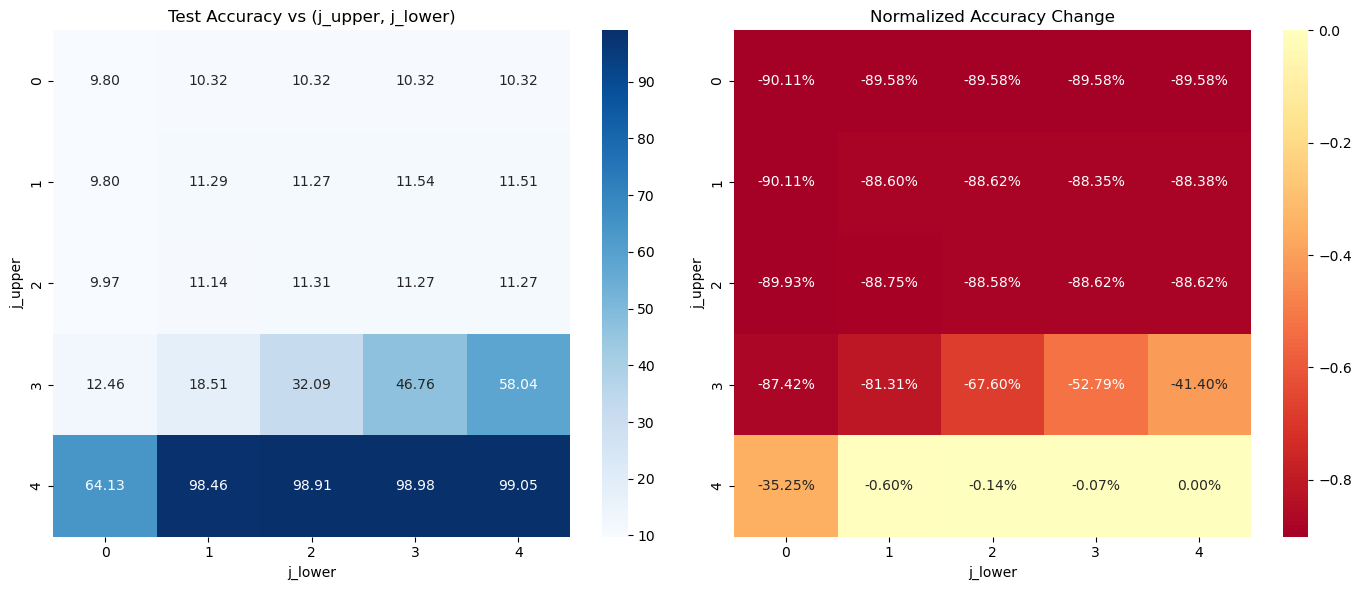


--- Summary for regular ---
 jU  jL    Changed   %Changed   Accuracy
--------------------------------------------------
  0   0  1,141,119     95.10%      9.80%
  0   1  1,123,200     93.61%     10.32%
  0   2  1,074,237     89.53%     10.32%
  0   3    975,159     81.27%     10.32%
  0   4    776,072     64.68%     10.32%
  1   0  1,141,119     95.10%      9.80%
  1   1  1,123,196     93.61%     11.29%
  1   2  1,074,226     89.53%     11.27%
  1   3    975,140     81.27%     11.54%
  1   4    776,035     64.68%     11.51%
  2   0  1,140,855     95.08%      9.97%
  2   1  1,122,507     93.55%     11.14%
  2   2  1,072,623     89.39%     11.31%
  2   3    971,792     80.99%     11.27%
  2   4    768,969     64.09%     11.27%
  3   0  1,134,366     94.54%     12.46%
  3   1  1,107,660     92.31%     18.51%
  3   2  1,040,335     86.70%     32.09%
  3   3    904,476     75.38%     46.76%
  3   4    631,320     52.62%     58.04%
  4   0  1,110,067     92.51%     64.13%
  4   1  1,055,411

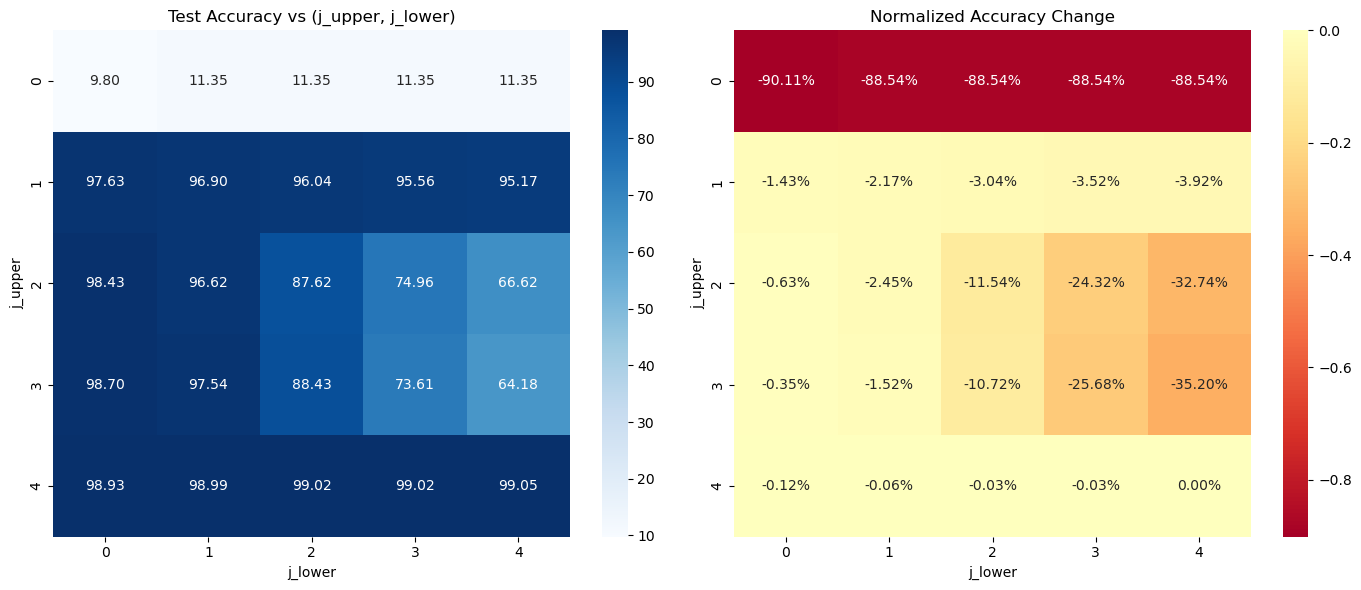


--- Summary for median ---
 jU  jL    Changed   %Changed   Accuracy
--------------------------------------------------
  0   0  1,199,882    100.00%      9.80%
  0   1  1,199,878    100.00%     11.35%
  0   2  1,199,871    100.00%     11.35%
  0   3  1,199,863    100.00%     11.35%
  0   4  1,199,845    100.00%     11.35%
  1   0  1,199,618     99.98%     97.63%
  1   1  1,199,193     99.94%     96.90%
  1   2  1,198,279     99.87%     96.04%
  1   3  1,196,534     99.72%     95.56%
  1   4  1,192,816     99.41%     95.17%
  2   0  1,193,393     99.46%     98.43%
  2   1  1,185,035     98.76%     96.62%
  2   2  1,167,594     97.31%     87.62%
  2   3  1,132,566     94.39%     74.96%
  2   4  1,062,233     88.53%     66.62%
  3   0  1,175,583     97.97%     98.70%
  3   1  1,147,633     95.65%     97.54%
  3   2  1,061,408     88.46%     88.43%
  3   3    895,896     74.67%     73.61%
  3   4    568,562     47.38%     64.18%
  4   0  1,145,226     95.44%     98.93%
  4   1  1,046,332 

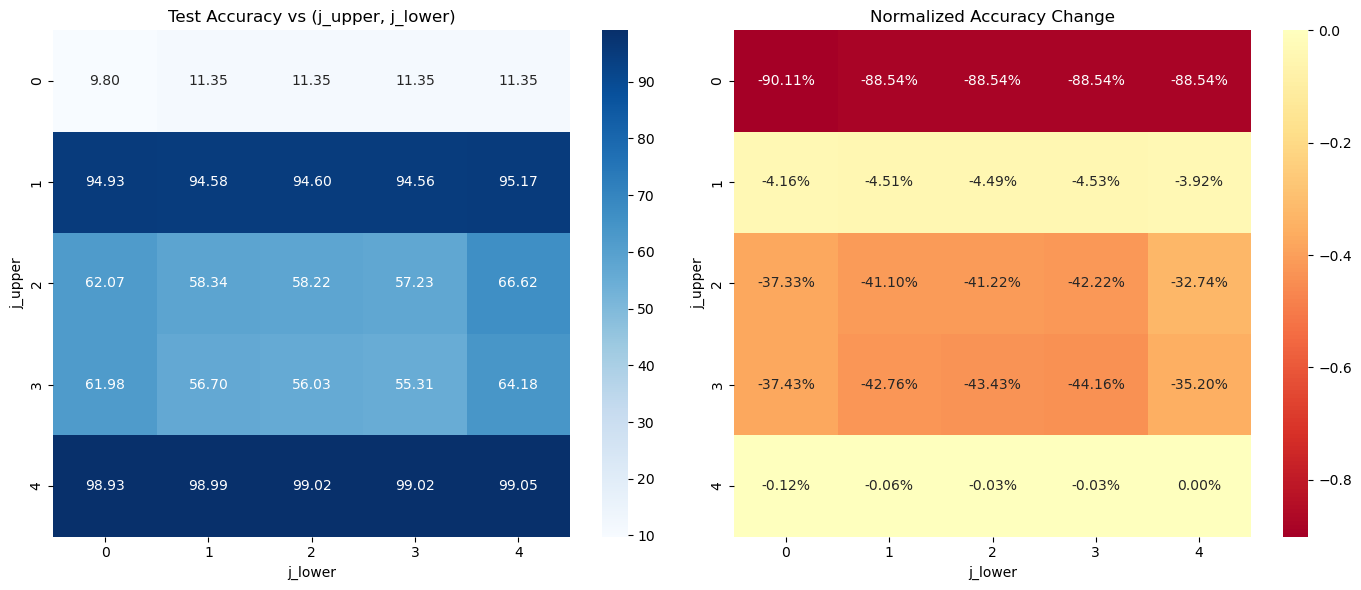


--- Summary for double_median ---
 jU  jL    Changed   %Changed   Accuracy
--------------------------------------------------
  0   0  1,199,878    100.00%      9.80%
  0   1  1,199,875    100.00%     11.35%
  0   2  1,199,874    100.00%     11.35%
  0   3  1,199,864    100.00%     11.35%
  0   4  1,199,845    100.00%     11.35%
  1   0  1,199,457     99.96%     94.93%
  1   1  1,198,968     99.92%     94.58%
  1   2  1,198,137     99.85%     94.60%
  1   3  1,196,164     99.69%     94.56%
  1   4  1,192,816     99.41%     95.17%
  2   0  1,191,524     99.30%     62.07%
  2   1  1,182,441     98.55%     58.34%
  2   2  1,164,854     97.08%     58.22%
  2   3  1,129,549     94.14%     57.23%
  2   4  1,062,233     88.53%     66.62%
  3   0  1,171,932     97.67%     61.98%
  3   1  1,113,657     92.81%     56.70%
  3   2  1,034,370     86.21%     56.03%
  3   3    872,548     72.72%     55.31%
  3   4    568,562     47.38%     64.18%
  4   0  1,145,226     95.44%     98.93%
  4   1  1,0

In [30]:
import os
import csv

def run_msb_sweep(label, quantized_model, test_loader, quant_params, msb_function, total_params):
    print(f"\n[4-{label}] Sweeping MSB Levels using '{label}' strategy...")
    results = sweep_half_msb_levels(quantized_model, test_loader, quant_params, msb_function)

    print(f"\n--- Summary for {label} ---")
    print(f"{'jU':>3} {'jL':>3} {'Changed':>10} {'%Changed':>10} {'Accuracy':>10}")
    print("-" * 50)
    for r in results:
        pct = (r["num_changed"] / total_params) * 100
        print(f"{r['j_upper']:>3} {r['j_lower']:>3} {r['num_changed']:>10,d} {pct:>9.2f}% {r['accuracy']:>9.2f}%")

    csv_path = f"results/half_msb_results_{label}.csv"
    os.makedirs("results", exist_ok=True)
    with open(csv_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)
    print(f"Results saved to: {csv_path}")

    hist_dir = f"results/weight_histograms_half_{label}"
    plot_half_weight_histograms(
        quantized_model,
        quant_params,
        msb_function=msb_function,
        output_dir=hist_dir,
        int8_mode=True
    )

# -----------------------------------------
# Main driver
# -----------------------------------------
def main():
    print("=" * 60)
    print("MSB Sensitivity Sweep on Quantized Model (Half-Byte Version)")
    print("=" * 60)

    print("\n[1] Initializing Original Model...")
    total_params = count_total_parameters(original_model)

    print("\n[2] Quantizing Model Weights to 8-bit...")
    os.makedirs("results", exist_ok=True)
    quantized_model, quant_params = quantize_model_weights(original_model)

    print("\n[3] Testing Quantized Model Without Perturbation")
    original_acc, _ = test_model(quantized_model, test_loader, model_name="Quantized No Perturbation")
    print(f"Original Quantized Accuracy: {original_acc:.2f}%")

    msb_functions = {
        "regular": make_halfbyte_msb_function("regular"),
        "median": make_halfbyte_msb_function("median"),
        "double_median": make_halfbyte_msb_function("double_median")

    }

    for label, msb_function in msb_functions.items():
        run_msb_sweep(
            label=label,
            quantized_model=quantized_model,
            test_loader=test_loader,
            quant_params=quant_params,
            msb_function=msb_function,
            total_params=total_params
        )

if __name__ == "__main__":
    main()